# Simple VGG16

Check the devices available. Note you need to have the right version (as in CPU vs GPU version) of TensorFlow installed to harnes the GPU. 

In [2]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allocator_type = 'BFC'
tf.Session(config = config)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5014224927300424084
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3388993536
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6862793787230359388
physical_device_desc: "device: 0, name: GeForce GTX 970, pci bus id: 0000:01:00.0, compute capability: 5.2"
]


This can take a bit of time if it's the first time you're running it. It will download a Keras model equivalent to VGG-16.

In [63]:
import keras
import numpy as np
from keras.applications import vgg16
from keras.preprocessing import image
from keras.layers import Input, Flatten, Dense
from keras.models import Model

#Load the VGG model
vgg_model = vgg16.VGG16(weights='imagenet', input_shape=(212,212,3), include_top=False, pooling='max')


# Train Model
Changing the last layer from 1000 prediction to 37 predictions
my_model is the vgg model if you want to use it later

In [89]:
from keras.optimizers import RMSprop

#Add a layer where input is the output of the  second last layer 
x = Dense(37, activation='sigmoid', name='predictions_m')(vgg_model.layers[-1].output)

#Then create the corresponding model 

optimizer = RMSprop(lr=1e-6)
my_model = Model(inputs=vgg_model.input, outputs=x)
my_model.compile(loss='mean_squared_error', optimizer=optimizer)
my_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 212, 212, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 212, 212, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 212, 212, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 106, 106, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 106, 106, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 106, 106, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 53, 53, 128)       0         
__________

# Paths
Remember to check for the path of the directory

In [90]:
import glob

def load_img_paths(target):
    '''
    Retrieve the full path of all images in the original training dataset
    '''
    return glob.glob(target + '/*.jpg')

data_dir = r'../data'
original_data_dir = data_dir + '/images_training_rev1'
training_dir      = data_dir + '/training'
validation_dir    = data_dir + '/validation'
test_dir          = data_dir + '/test'

# Load image file names
train_paths = load_img_paths(training_dir)
valid_paths = load_img_paths(validation_dir)
test_paths = load_img_paths(test_dir)
train_paths[0:5]

['../data/training\\100023.jpg',
 '../data/training\\100128.jpg',
 '../data/training\\100143.jpg',
 '../data/training\\100237.jpg',
 '../data/training\\100335.jpg']

In [91]:
from keras.preprocessing.image import load_img

image = load_img(train_paths[0], target_size=(224, 224))

from keras.preprocessing.image import img_to_array
# convert the image pixels to a numpy array
image = img_to_array(image)

The network expects one or more images as input; that means the input array will need to be 4-dimensional: samples, rows, columns, and channels.

We only have one sample (one image). We can reshape the array by calling reshape() and adding the extra dimension.

In [92]:
from keras.applications.vgg16 import preprocess_input
import pandas as pd
import numpy as np

# # reshape data for the model
# image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

# # prepare the image for the VGG model
# image = preprocess_input(image)

# # predict the probability across all output classes
# output = my_model.predict(image)

df = pd.read_csv(data_dir + '/training_solutions_rev1.csv')
df.head()

,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,...,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,100008,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,...,0.000000,0.279952,0.138445,0.000000,0.000000,0.092886,0.0,0.0,0.0,0.325512
1,100023,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,...,0.018764,0.000000,0.131378,0.459950,0.000000,0.591328,0.0,0.0,0.0,0.000000
2,100053,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
3,100078,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,...,0.000000,0.094549,0.000000,0.094549,0.189098,0.000000,0.0,0.0,0.0,0.000000
4,100090,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000


# Extracting
Getting the training data number from the path

In [93]:
from os import path # removes confusion with / and \ (windows)
file_id = path.split(train_paths[0])[-1] \
              .split('.')[0] # remove file extension
fd = int(file_id)

row = df.loc[df['GalaxyID'] == fd].loc[:,df.columns != 'GalaxyID']
row

,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,Class5.1,...,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
1,0.327001,0.663777,0.009222,0.031178,0.632599,0.46737,0.165229,0.591328,0.041271,0.0,...,0.018764,0.0,0.131378,0.45995,0.0,0.591328,0.0,0.0,0.0,0.0


## Training

In [94]:
from skimage.transform import resize
from skimage.io import imread

def preprocess_image(fname):
    sample_img = imread(train_paths[0])
    sample_img = sample_img.T[:,106:106*3,106:106*3]
    sample_img = resize(sample_img, (3, 212, 212), mode='reflect')
    return sample_img.T



In [95]:
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

# Will output sequence of tuples (image, test) given a datapath
def fetch_images(paths):
    for fname in paths:
        image = preprocess_image(fname)
        image = img_to_array(image)
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        train = preprocess_input(image)
        file_id = path.split(fname)[-1] \
                      .split('.')[0]
        fd = int(file_id)
        test = df.loc[df['GalaxyID'] == fd].loc[:,df.columns != 'GalaxyID']
        yield (train, [test])
        
early_stopping = EarlyStopping(monitor='val_loss', patience=7, verbose=1, mode='auto')

# create weights file if it doesn't exist for ModelCheckpoint
from os import mkdir
try: 
    mkdir('tmp')
except FileExistsError:
    print('tmp directory already exists')
checkpointer = ModelCheckpoint(filepath='tmp/weights.hdf5', verbose=1, save_best_only=True)

# history function
history = LossHistory()

tmp directory already exists


In [96]:
batch_size = 32
steps_per_epoch  = len(train_paths) / batch_size
validation_steps = len(valid_paths) / batch_size
hist = my_model.fit_generator(fetch_images(train_paths),
    steps_per_epoch=steps_per_epoch, 
    epochs=50,
    validation_data=fetch_images(valid_paths),
    validation_steps=validation_steps,
    verbose=2,
    callbacks=[history,checkpointer,early_stopping]
)

Epoch 1/50
 - 23s - loss: 0.1778 - val_loss: 0.1031

Epoch 00001: val_loss improved from inf to 0.10314, saving model to tmp/weights.hdf5
Epoch 2/50
 - 19s - loss: 0.1018 - val_loss: 0.1002

Epoch 00002: val_loss improved from 0.10314 to 0.10022, saving model to tmp/weights.hdf5
Epoch 3/50
 - 19s - loss: 0.1010 - val_loss: 0.0995

Epoch 00003: val_loss improved from 0.10022 to 0.09947, saving model to tmp/weights.hdf5
Epoch 4/50
 - 19s - loss: 0.1012 - val_loss: 0.0996

Epoch 00004: val_loss did not improve from 0.09947
Epoch 5/50
 - 19s - loss: 0.0894 - val_loss: 0.0811

Epoch 00005: val_loss improved from 0.09947 to 0.08109, saving model to tmp/weights.hdf5
Epoch 6/50
 - 19s - loss: 0.0780 - val_loss: 0.0826

Epoch 00006: val_loss did not improve from 0.08109
Epoch 7/50
 - 20s - loss: 0.0742 - val_loss: 0.0588

Epoch 00007: val_loss improved from 0.08109 to 0.05878, saving model to tmp/weights.hdf5
Epoch 8/50
 - 19s - loss: 0.0629 - val_loss: 0.0602

Epoch 00008: val_loss did not imp

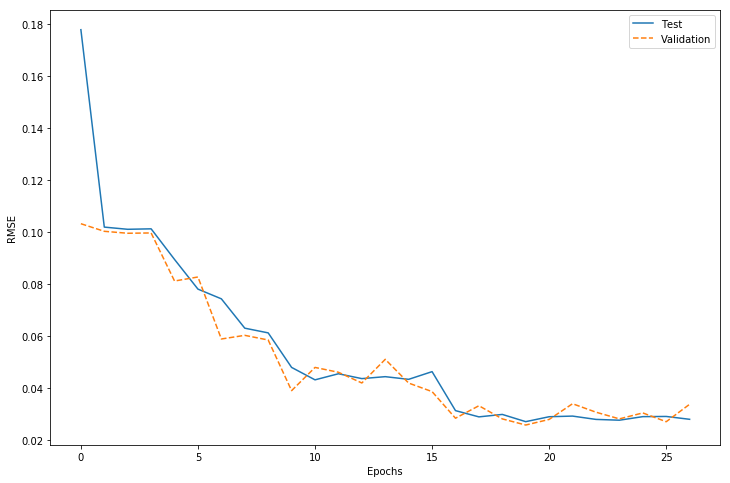

In [97]:
import matplotlib.pylab as plt
%matplotlib inline

plt.figure(figsize=(12,8))
plt.plot(hist.epoch,hist.history['loss'],    label='Test')
plt.plot(hist.epoch,hist.history['val_loss'],label='Validation',linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [98]:
len(train_paths)/32

312.5

In [99]:
len(valid_paths)/32

39.0625